# Experimentation Notebook  

**Goal**  
finding the best methods for analysing the dataset, deciding what models to do hyperparametertuning on

------
Content:
1. Loading & Manipulating Data (Onehot encoding method)  
2. Experiment with Data on  
    i. Linear Regression to get an understanding of correlation  
    ii. Regression Models   
    iii. Classifcation Models  
    iv. Neural Network  
3. Conclusion
------
It is important to notice that the main focus is to predict "tdf attended" as True, therefore that the prediction of True Positives is central. As we want to balance True Psotive accuracy on bot sides F1 score is used to evaluate models.

## 1. Data Preperation

### I. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
preprocessed_df = pd.read_csv("../data manipulation/preprocessed_cycling_tdf.csv", index_col=0)

### II. Split Train-Test
2023 is test data, before train data

In [3]:
# split into train data (pre 2023), and test data 2023

test_df = preprocessed_df[preprocessed_df['season'] == 2023]
train_df = preprocessed_df[preprocessed_df['season'] != 2023]

In [4]:
# now remove season time series data

test_df = test_df.drop("season", axis=1)
train_df = train_df.drop("season", axis=1)

In [5]:
# split train and test into X, Y

columns = [column for column in list(test_df.columns) if column != "tdf attended"]

X_test = test_df[columns]
Y_test = test_df[["tdf attended"]]

X_train = train_df[columns]
Y_train = train_df[["tdf attended"]]

In [6]:
print(X_test.columns.tolist())
print(X_train.columns.tolist())

['age', 'height', 'weight', 'pcs points till tdf', 'uci points till tdf', 'race days till tdf', 'vuelta attended', 'giro attended', 'last season pcs points', 'last season uci points', 'team__AG2R Prevoyance', 'team__Accent.jobs – Willems Veranda’s', 'team__Argos - Shimano', 'team__Astana Pro Team', 'team__BKCP - Powerplus', 'team__BMC Racing Team', 'team__Bahrain Merida Pro Cycling Team', 'team__Bonjour - Toupargel', 'team__Cofidis, le Crédit par Téléphone', 'team__Cycling Academy Team', 'team__EF Education First', 'team__Euskadi - Petronor', 'team__FDJ', 'team__Fondas P3 Transfer Team', 'team__Fortuneo - Oscaro', 'team__Geox-TMC Transformers', 'team__HTC - High Road', 'team__IAM Cycling', 'team__Lampre - Daikin', 'team__Liquigas-Pata', 'team__Lotto - Super Club', 'team__Movistar Team', 'team__Quick-Step Floors', 'team__RadioShack', 'team__Sky Procycling', 'team__Superconfex - Yoko - Opel', 'team__Team Dimension Data', 'team__Team Home - Jack & Jones', 'team__Team Jayco AlUla', 'team__

### III. Create local train, test sets
### IV. Differentiate between data with team or without team

In [7]:
# function that creates local copy of X,Y for train and test
# and takes bool to include team data or not


def local_variables(with_teams = True):
    """function that creates local copy of X,Y for train and test
         and takes bool weither to include team data or not"""
    columns = X_test.columns.tolist()
    if not with_teams:
        columns_no_teams = []
        for column in columns:
            if column[:4] != "team":
                columns_no_teams.append(column)
        columns = columns_no_teams
    X_test_n = X_test.copy()[columns]
    X_train_n = X_train.copy()[columns]

    return X_test_n , Y_test.copy(), X_train_n, Y_train.copy()


X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables()
print(X_test_local.columns.tolist())
X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)
print(X_test_local.columns.tolist())

['age', 'height', 'weight', 'pcs points till tdf', 'uci points till tdf', 'race days till tdf', 'vuelta attended', 'giro attended', 'last season pcs points', 'last season uci points', 'team__AG2R Prevoyance', 'team__Accent.jobs – Willems Veranda’s', 'team__Argos - Shimano', 'team__Astana Pro Team', 'team__BKCP - Powerplus', 'team__BMC Racing Team', 'team__Bahrain Merida Pro Cycling Team', 'team__Bonjour - Toupargel', 'team__Cofidis, le Crédit par Téléphone', 'team__Cycling Academy Team', 'team__EF Education First', 'team__Euskadi - Petronor', 'team__FDJ', 'team__Fondas P3 Transfer Team', 'team__Fortuneo - Oscaro', 'team__Geox-TMC Transformers', 'team__HTC - High Road', 'team__IAM Cycling', 'team__Lampre - Daikin', 'team__Liquigas-Pata', 'team__Lotto - Super Club', 'team__Movistar Team', 'team__Quick-Step Floors', 'team__RadioShack', 'team__Sky Procycling', 'team__Superconfex - Yoko - Opel', 'team__Team Dimension Data', 'team__Team Home - Jack & Jones', 'team__Team Jayco AlUla', 'team__

## 2. Experiment with Data

In [8]:
print("Actual positives", Y_test['tdf attended'].sum())
print("Actual negatives", (~Y_test['tdf attended']).sum())

Actual positives 144
Actual negatives 408


### I. Savety check for nan values before starting

In [9]:
def columns_with_nan(df):
    # Find columns with NaN values
    nan_columns = df.columns[df.isna().any()].tolist()

    return nan_columns
def count_nan_values_per_column(df):
    # Count NaN values in each column
    nan_counts_per_column = df.isna().sum()

    return nan_counts_per_column
X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)
print(count_nan_values_per_column(X_train_local))

age                       0
height                    0
weight                    0
pcs points till tdf       0
uci points till tdf       0
race days till tdf        0
vuelta attended           0
giro attended             0
last season pcs points    0
last season uci points    0
dtype: int64


### II. Linear regression
to get an overview of correlation

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
def linear_regression_equation(X, Y):

    model = LinearRegression()
    model.fit(X, Y)

    results = {}
    features = list(model.feature_names_in_)
    coefficients = model.coef_.tolist()[0]
    for i in range(len(features)):
        results[features[i]]=coefficients[i]
    return results



X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)
result = linear_regression_equation(X_train_local, Y_train_local)

print("with team one hot:")
sorted_dict = dict(sorted(result.items(), key=lambda item: abs(item[1]), reverse=True))

for key, value in sorted_dict.items():
    print(f'{key}: {value}')


with team one hot:
last season pcs points: 1.3356152489555064
age: 0.4605607341143679
uci points till tdf: 0.3970957795615063
height: 0.3221969851684255
pcs points till tdf: 0.32063005099242947
giro attended: -0.25961850573860457
weight: -0.218593704242029
race days till tdf: 0.20504568963531664
vuelta attended: -0.1573491083060834
last season uci points: -0.12136282956095347


high impact: pcs points last season

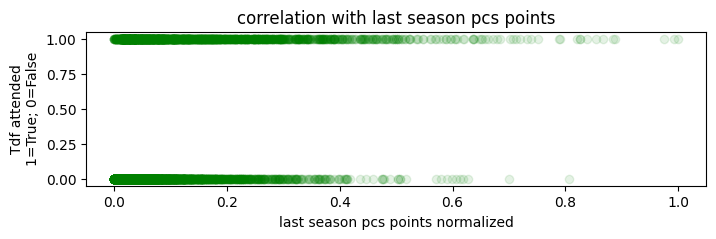

In [12]:
# Example high correlation 2
# Plot correlation of last season pcs points and tdf attended
plt.figure(figsize=(8,2))
    
plt.scatter(preprocessed_df["last season pcs points"], preprocessed_df["tdf attended"], c="green", alpha=0.1)
plt.xlabel("last season pcs points normalized")
plt.ylabel("Tdf attended\n1=True; 0=False")
plt.title("correlation with last season pcs points")
plt.show()

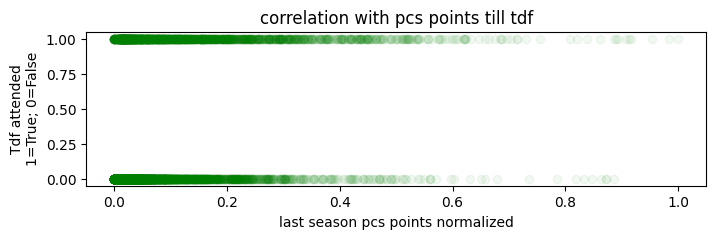

In [13]:
plt.figure(figsize=(8,2))
    
plt.scatter(preprocessed_df["pcs points till tdf"], preprocessed_df["tdf attended"], c="green", alpha=0.05)
plt.xlabel("last season pcs points normalized")
plt.ylabel("Tdf attended\n1=True; 0=False")
plt.title("correlation with pcs points till tdf")
plt.show()

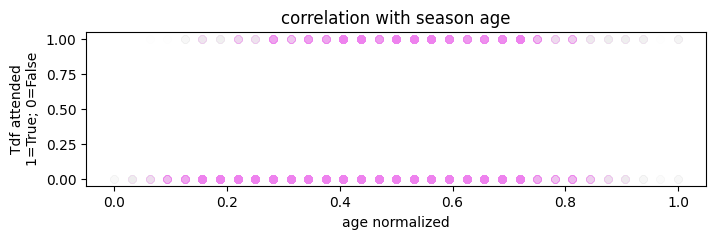

In [14]:
# Example high correlation 2
# Plot correlation of last season pcs points and tdf attended
plt.figure(figsize=(8,2))
    
plt.scatter(preprocessed_df["age"], preprocessed_df["tdf attended"], c="violet", alpha=0.002)
plt.xlabel("age normalized")
plt.ylabel("Tdf attended\n1=True; 0=False")
plt.title("correlation with season age")
plt.show()

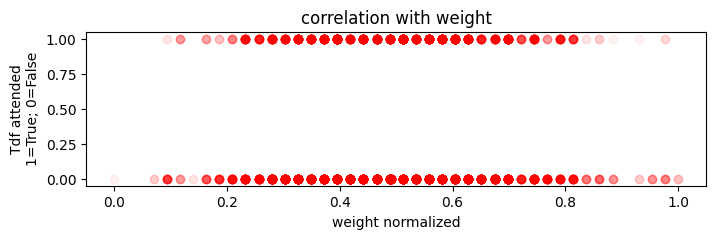

In [15]:
# Example low correlation
# Plot correlation of last season uci points and tdf attended
plt.figure(figsize=(8,2))
    
plt.scatter(preprocessed_df["weight"], preprocessed_df["tdf attended"], c="red", alpha=0.05)
plt.xlabel("weight normalized")
plt.ylabel("Tdf attended\n1=True; 0=False")
plt.title("correlation with weight")
plt.show()

### III. Regression Models

with teams

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(True)


# KNN Regression
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_local, Y_train_local)
knn_regressor_predictions = knn_regressor.predict(X_test_local)


# Decision Tree Regression
decision_tree_regressor = DecisionTreeRegressor(random_state=42)
decision_tree_regressor.fit(X_train_local, Y_train_local)
decision_tree_regressor_predictions = decision_tree_regressor.predict(X_test_local)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train_local, Y_train_local)
linear_regression_predictions = linear_regression.predict(X_test_local)

# Print regression metrics (for KNN Regression, Decision Tree Regression, and Linear Regression)
print("\nKNN Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, knn_regressor_predictions))

print("\nDecision Tree Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, decision_tree_regressor_predictions))

print("\nLinear Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, linear_regression_predictions))



KNN Regression Mean Squared Error:
0.19594202898550728

Decision Tree Regression Mean Squared Error:
0.34782608695652173

Linear Regression Mean Squared Error:
1.651713463297345e+23


without teams:

In [17]:


X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)


# KNN Regression
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_local, Y_train_local)
knn_regressor_predictions = knn_regressor.predict(X_test_local)


# Decision Tree Regression
decision_tree_regressor = DecisionTreeRegressor(random_state=42)
decision_tree_regressor.fit(X_train_local, Y_train_local)
decision_tree_regressor_predictions = decision_tree_regressor.predict(X_test_local)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train_local, Y_train_local)
linear_regression_predictions = linear_regression.predict(X_test_local)

# Print regression metrics (for KNN Regression, Decision Tree Regression, and Linear Regression)
print("\nKNN Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, knn_regressor_predictions))

print("\nDecision Tree Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, decision_tree_regressor_predictions))

print("\nLinear Regression Mean Squared Error:")
print(mean_squared_error(Y_test_local, linear_regression_predictions))



KNN Regression Mean Squared Error:
0.1927536231884058

Decision Tree Regression Mean Squared Error:
0.3605072463768116

Linear Regression Mean Squared Error:
0.17008822448042704


Example ROC, with linear regression and without teams, since this model hast smalles MSE

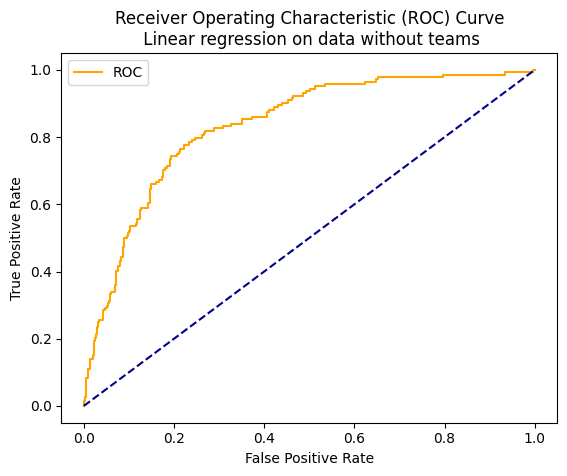

In [18]:
from sklearn import metrics

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)


linear_regression = LinearRegression()
linear_regression.fit(X_train_local, Y_train_local)
linear_regression_predictions = linear_regression.predict(X_test_local)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_local, linear_regression_predictions)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\n Linear regression on data without teams')
plt.legend()
plt.show()

classificaiton report on linear regression

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

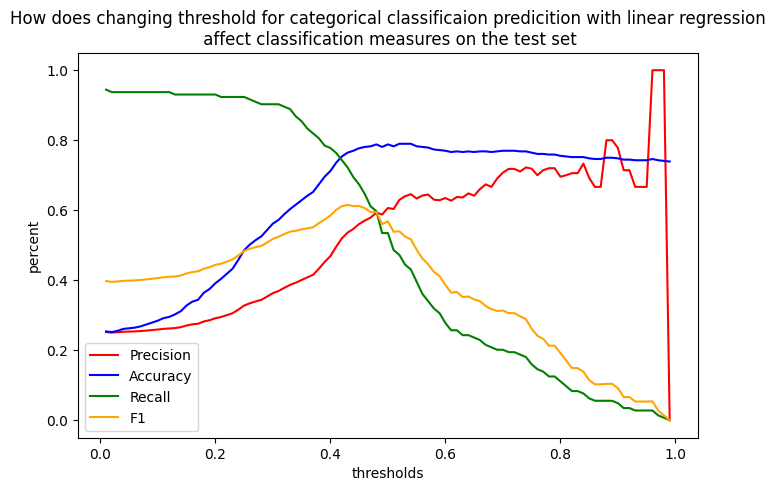

In [19]:
X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)


linear_regression = LinearRegression()
linear_regression.fit(X_train_local, Y_train_local)
linear_regression_predictions = linear_regression.predict(X_test_local)
linear_regression_predictions = [element[0] for element in linear_regression_predictions]


def to_bool(value):
    if value == 1:
        return True
    else:
        return False
        
def round_value(value, threshold):
    if value < threshold:
        return 0
    elif value >= threshold and value <= 1:
        return 1



thresholds = [0.01*t for t in range(1,100)]
precisions = []
accuracies = []
recalls = []
fones = []
for threshold in thresholds:
    Y_pred = [to_bool(round_value(value, threshold)) for value in linear_regression_predictions]
    report = classification_report(Y_test_local, Y_pred, output_dict=True)
    precisions.append(report["True"]["precision"])
    accuracies.append(report["accuracy"])
    recalls.append(report["True"]["recall"])
    fones.append(report["True"]["f1-score"])

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, c="red", label="Precision")
plt.plot(thresholds, accuracies, c="blue", label="Accuracy")
plt.plot(thresholds, recalls, c="green", label="Recall")
plt.plot(thresholds, fones, c="orange", label="F1")

plt.xlabel("thresholds")
plt.ylabel("percent")
plt.title("How does changing threshold for categorical classificaion predicition with linear regression\n affect classification measures on the test set")
plt.legend()
plt.show()

In [20]:
max_index = 0
for i in range(1,len(fones)):
    if fones[i] > fones[max_index]:
        max_index=i
print("optimal point is at threshold: ", thresholds[max_index])
print("F1: ", fones[max_index])
print("Precision: ", precisions[max_index])

optimal point is at threshold:  0.43
F1:  0.6153846153846153
Precision:  0.5360824742268041


It can be seen that striving for high precision only would have negative effect on recall. Other way around it is similar, as we want to balance the outcome for TP, we go for F1 as our measure of choice

### IV. Classifiers
with teams

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(True)


# KNN Classification
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_local, Y_train_local)
knn_classifier_predictions = knn_classifier.predict(X_test_local)

# Decision Tree Classification
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train_local, Y_train_local)
decision_tree_classifier_predictions = decision_tree_classifier.predict(X_test_local)

## ENSEMBLES
# AdaBoost Classifier 
adaboost_classifier = AdaBoostClassifier(random_state=42)
adaboost_classifier.fit(X_train_local, Y_train_local)
adaboost_predictions = adaboost_classifier.predict(X_test_local)

# Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_local, Y_train_local)
random_forest_predictions = random_forest_classifier.predict(X_test_local)

# Naive Bayes
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train_local, Y_train_local)
naive_bayes_predictions = naive_bayes_classifier.predict(X_test_local)



# Print classification reports (for KNN and Decision Tree)
print("KNN Classification Report:")
print(classification_report(Y_test_local, knn_classifier_predictions))

print("\nDecision Tree Classification Report:")
print(classification_report(Y_test_local, decision_tree_classifier_predictions))


print("-"*10, "Enselmbles", "-"*10)

print("AdaBoost Classification Report:")
print(classification_report(Y_test_local, adaboost_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test_local, random_forest_predictions))

print("\nNaive Bayes Classification Report:")
print(classification_report(Y_test_local, naive_bayes_predictions))


C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

KNN Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.78      0.81       408
        True       0.48      0.57      0.52       144

    accuracy                           0.73       552
   macro avg       0.66      0.68      0.67       552
weighted avg       0.74      0.73      0.74       552


Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.66      0.73       408
        True       0.38      0.58      0.46       144

    accuracy                           0.64       552
   macro avg       0.60      0.62      0.59       552
weighted avg       0.70      0.64      0.66       552

---------- Enselmbles ----------
AdaBoost Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.70      0.79       408
        True       0.49      0.81      0.61       144

    accuracy                           0.73       55

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


without teams

In [22]:

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)


# KNN Classification
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_local, Y_train_local)
knn_classifier_predictions = knn_classifier.predict(X_test_local)

# Decision Tree Classification
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train_local, Y_train_local)
decision_tree_classifier_predictions = decision_tree_classifier.predict(X_test_local)

## ENSEMBLES
# AdaBoost Classifier 
adaboost_classifier = AdaBoostClassifier(random_state=42)
adaboost_classifier.fit(X_train_local, Y_train_local)
adaboost_predictions = adaboost_classifier.predict(X_test_local)

# Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_local, Y_train_local)
random_forest_predictions = random_forest_classifier.predict(X_test_local)

# Naive Bayes
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train_local, Y_train_local)
naive_bayes_predictions = naive_bayes_classifier.predict(X_test_local)



# Print classification reports (for KNN and Decision Tree)
print("KNN Classification Report:")
print(classification_report(Y_test_local, knn_classifier_predictions))

print("\nDecision Tree Classification Report:")
print(classification_report(Y_test_local, decision_tree_classifier_predictions))


print("-"*10, "Enselmbles", "-"*10)

print("AdaBoost Classification Report:")
print(classification_report(Y_test_local, adaboost_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test_local, random_forest_predictions))

print("\nNaive Bayes Classification Report:")
print(classification_report(Y_test_local, naive_bayes_predictions))


C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

KNN Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.73      0.79       408
        True       0.46      0.65      0.54       144

    accuracy                           0.71       552
   macro avg       0.66      0.69      0.66       552
weighted avg       0.75      0.71      0.72       552


Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.66      0.73       408
        True       0.38      0.58      0.46       144

    accuracy                           0.64       552
   macro avg       0.60      0.62      0.59       552
weighted avg       0.70      0.64      0.66       552

---------- Enselmbles ----------
AdaBoost Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.72      0.80       408
        True       0.49      0.78      0.60       144

    accuracy                           0.73       55

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Example ROC on best performin method is Random Forrest with F1 0.61 for True values with teams.

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


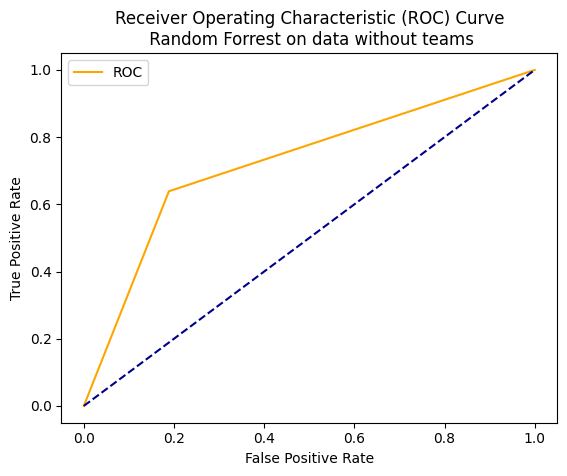

In [23]:
from sklearn import metrics

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(True)


random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_local, Y_train_local)
random_forest_predictions = random_forest_classifier.predict(X_test_local)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_local, random_forest_predictions)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\n Random Forrest on data without teams')
plt.legend()
plt.show()

do now a 10-fold cross validation on RF without teams

In [24]:
from sklearn.model_selection import cross_val_score, KFold

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(True)

random_forest_classifier = RandomForestClassifier(random_state=42)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(random_forest_classifier, X_train_local, Y_train_local, cv=kf, scoring="f1")

# Print the cross-validation scores
print("Cross-validation precison scores:", cross_val_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean F1:", np.mean(cross_val_scores))
print("Standard deviation:", np.std(cross_val_scores))

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Cross-validation precison scores: [0.61627907 0.54925373 0.60053619 0.51592357 0.62345679 0.63636364
 0.5982906  0.5862069  0.61096606 0.67955801]
Mean F1: 0.6016834550839589
Standard deviation: 0.04289105284509619


While the Random Forrest works well on a validation dataset (random data 2010-2022) it does not work so well on new data (test data).  

on test data: 0.61 F1  
on 10 fold validation: 0.60 F1

#### IV. Neural Network

In [25]:
from sklearn.neural_network import MLPClassifier


X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(True)

# Create and train the MLP Classifier
ann_classifier = MLPClassifier(max_iter=1000)
ann_classifier.fit(X_train_local, Y_train_local)

# Make predictions on the test set
Y_pred = ann_classifier.predict(X_test_local)

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)

# Create and train the MLP Classifier
ann_classifier = MLPClassifier(max_iter=1000)
ann_classifier.fit(X_train_local, Y_train_local)

# Make predictions on the test set
Y_pred2 = ann_classifier.predict(X_test_local)

print("Classification Report ANN with teams:\n")
print(classification_report(Y_test_local, Y_pred))


print("Classification Report ANN withOUT teams:\n")
print(classification_report(Y_test_local, Y_pred2))

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report ANN with teams:

              precision    recall  f1-score   support

       False       0.87      0.69      0.77       408
        True       0.44      0.70      0.54       144

    accuracy                           0.69       552
   macro avg       0.66      0.70      0.66       552
weighted avg       0.76      0.69      0.71       552

Classification Report ANN withOUT teams:

              precision    recall  f1-score   support

       False       0.90      0.76      0.83       408
        True       0.53      0.75      0.62       144

    accuracy                           0.76       552
   macro avg       0.71      0.76      0.72       552
weighted avg       0.80      0.76      0.77       552



F1 score is higher for performance without teams, therefore

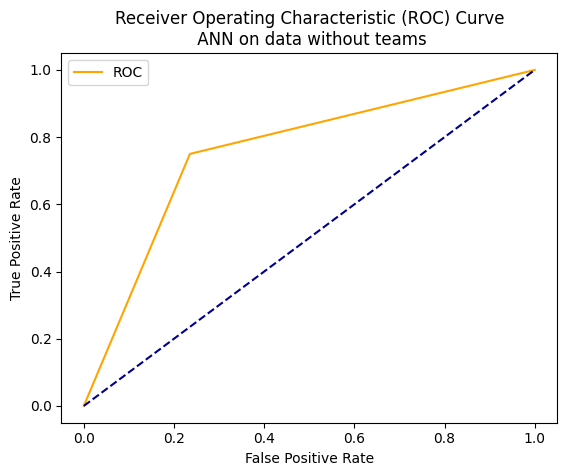

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_local, Y_pred2)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\n ANN on data without teams')
plt.legend()
plt.show()


In [27]:
# NOw again 10 fold cross validation

X_test_local, Y_test_local, X_train_local, Y_train_local = local_variables(False)

# Create and train the MLP Classifier
ann_classifier = MLPClassifier(max_iter=1000)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(ann_classifier, X_train_local, Y_train_local, cv=kf, scoring="f1")

# Print the cross-validation scores
print("Cross-validation precison scores:", cross_val_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean Precision:", np.mean(cross_val_scores))
print("Standard deviation:", np.std(cross_val_scores))

C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hutte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y

Cross-validation precison scores: [0.61202186 0.56571429 0.61964736 0.60410557 0.60655738 0.60518732
 0.66666667 0.61666667 0.63589744 0.66836735]
Mean Precision: 0.6200831883752469
Standard deviation: 0.02905927517852739


on test data: 0.62 F1  
on 10-vold train validation: 0.68

## 3. Conclusion

| Model Class | Best Performed Model |With Team Data| F1 on test set in $\%$| Precision in  $\%$|10-fold cross validation success intervall in $\%$|  
|-|-|-|-|-|-|
|Regression|Linear Regression ( Threshold $0.43$)| $True$|$61$|$54$||  
|Classification| Random Forrest Ensemble | $True$|$59$|$54$|$[56,64]$|  
|Neural Networks|MLP|$False$|$62$|$51$|$[59,65]$|  

Since the methods are (suprisingly) quite similar in perfomance. I will choose Classification (Random Forrest) as the choosen